In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, evidence_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork
from src.python.models import HierarchicalSdtMptSimulator, MainSimulator
from src.python.losses import multi_task_loss, softmax_loss
from src.python.helpers import n_clust_obs_f_f, get_multiple_predictions, get_preds_and_bfs
from src.python.visualization import perf_tester, plot_calibration_curve, plot_calibration_curve_repetition_uncertainty

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.optimizers import Adam
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer
from bayesflow.losses import log_loss

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Set up networks

In [3]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
evidence_net = EvidentialNetwork(evidence_meta_validation)

amortizer = MultiModelAmortizer(evidence_net, summary_net)

simulator = MainSimulator(HierarchicalSdtMptSimulator())

In [4]:
# Training steps
epochs=15 
iterations_per_epoch=1000

# Cosine decaying learning rate
initial_lr = 0.0005
decay_steps = epochs*iterations_per_epoch
alpha = 0
lr_schedule = CosineDecay(
    initial_lr, decay_steps, alpha=alpha
    )

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = "c:\\Users\\lasse\\documents\\hierarchical model comparison project\\checkpoints\\02_bridge_sampling_comparison\\non_nested_models"

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    #loss=partial(multi_task_loss, kl_weight=0.25),
    loss=partial(softmax_loss),
    optimizer=partial(Adam, lr_schedule),
    #checkpoint_path=checkpoint_path,
    skip_checks=True,
    )

# Sample size
n_clusters = 25
n_obs = 50

# Train

In [5]:
training_time_start = perf_counter()
losses = trainer.train_online(
    epochs=epochs, iterations_per_epoch=iterations_per_epoch, batch_size=32, 
    n_obs=partial(n_clust_obs_f_f, n_clusters, n_obs), n_vars=2)
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

# Validate

In [14]:
# Simulate data
n_data_sets = 5000

m_val, _, x_val = simulator(batch_size=n_data_sets, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2)
val_data = {'X' : x_val, 'm' : m_val}

In [7]:
m_soft_samples = np.stack([np.array(evidence_net.predict(summary_net(x_val), output_softmax=True)['m_probs'][:, 1], dtype = np.longdouble) for _ in range(100)])
m_soft_mean = np.mean(m_soft_samples, axis=0)
m_soft_sd = np.std(m_soft_samples, axis=0)

In [24]:
from src.python.settings import plotting_settings

import numpy as np
np.set_printoptions(suppress=True)
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams.update({'mathtext.fontset': 'cm'}) # Enable mathcal for model labels
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error

# Performance of the MC Dropout output


def plot_confusion_matrix(m_true, m_pred, model_names, ax, normalize=True, 
                          cmap='viridis', annotate=True, title=True):
    """
    Helper function to print and plot the confusion matrix. 
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    cm = confusion_matrix(m_true, m_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, shrink=0.7)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]))

    ax.set_xticklabels(model_names, fontsize=plotting_settings['fontsize_labels'])
    ax.set_yticklabels(model_names, fontsize=plotting_settings['fontsize_labels'])
    ax.set_xlabel('Predicted model', fontsize=plotting_settings['fontsize_labels'])
    ax.set_ylabel('True model', fontsize=plotting_settings['fontsize_labels']) 

    # Loop over data dimensions and create text annotations.
    if annotate:
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] < thresh else "black")
    if title:
        ax.set_title('Confusion Matrix')

    
def plot_calibration_curve(m_true, m_pred, n_bins, ax, xlabel=True, ylabel=True, title=None, show_ece=True):
    """Helper function to plot the calibration curve and ece."""
    
    prob_true, prob_pred = calibration_curve(m_true, m_pred, n_bins=n_bins)
    cal_err = np.mean(np.abs(prob_true - prob_pred))

    ax.plot((0,1), (0,1), '--', color='darkgrey')
    ax.plot(prob_true, prob_pred, color=plotting_settings['colors_discrete'][0])
    print('ECE = {0:.3f}'.format(cal_err))

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    if xlabel:
        ax.set_xlabel('Accuracy',  fontsize=plotting_settings['fontsize_labels'])
    if ylabel:
        ax.set_ylabel('Confidence',  fontsize=plotting_settings['fontsize_labels'])
    ax.set_title(title, fontsize=plotting_settings['fontsize_title'])
    ax.grid(alpha=.3)
    if show_ece:
        ax.text(0.1, 0.9, r'$\widehat{{\mathrm{{ECE}}}} = {0:.3f}$'.format(cal_err),
                horizontalalignment='left', verticalalignment='center',
                transform=ax.transAxes, size=12)
    sns.despine(ax=ax)
    
    
def plot_bootstrap_accuracy(m_true, m_pred, n_bootstrap, ax):
    """Helper function to plot the bootstrap accuracy of recovery."""
    
    n_test = m_true.shape[0]
    accs = []
    for bi in range(n_bootstrap):
        b_idx = np.random.choice(np.random.permutation(n_test), size=n_test, replace=True)
        m_true_b, m_pred_b = m_true[b_idx], m_pred[b_idx]
        accs.append(accuracy_score(m_true_b, m_pred_b))
    
    sns.histplot(accs, ax=ax, stat='probability', color=plotting_settings['colors_discrete'][0])
    sns.despine(ax=ax)
    ax.set_xlabel('Accuracy', fontsize=plotting_settings['fontsize_labels'])
    ax.set_ylabel('')
    ax.yaxis.set_ticks([])
    ax.text(0.05, 0.9,  'Bootstrap accuracy = {0:.3f}'.format(np.mean(accs)),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    ax.text(0.05, 0.8,  'SD = {0:.3f}'.format(np.std(accs)),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    
    
def plot_bootstrap_mae(m_true, m_pred, n_bootstrap, ax):
    """Helper function to plot the bootstrap mean absolute error."""
    
    n_test = m_true.shape[0]
    maes = []
    for bi in range(n_bootstrap):
        b_idx = np.random.choice(np.random.permutation(n_test), size=n_test, replace=True)
        m_true_b, m_pred_b = m_true[b_idx], m_pred[b_idx]
        maes.append(mean_absolute_error(m_true_b, m_pred_b))
    
    sns.histplot(maes, ax=ax, stat='probability', color=plotting_settings['colors_discrete'][0])
    sns.despine(ax=ax)
    ax.set_xlabel('MAE', fontsize=plotting_settings['fontsize_labels'])
    ax.set_ylabel('')
    ax.yaxis.set_ticks([])
    ax.text(0.05, 0.9,  'Mean MAE = {0:.3f}'.format(np.mean(maes)),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    ax.text(0.05, 0.8,  'SD = {0:.3f}'.format(np.std(maes)),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        size=12)
    

def perf_tester_dropout(evidence_net, summary_net, val_data, output_softmax=False, n_bootstrap=100, n_cal_bins=15, pub_style=False, save=False):
    """Helper function to test the performance of the model."""
    
    # Compute model predictions in chunks so GPU memory does not blow-up
    m_soft = np.mean(np.stack([np.array(evidence_net.predict(summary_net(x_val), output_softmax=True)['m_probs'][:, 1], dtype = np.longdouble) for _ in range(100)]), axis=0)
    m_hard = (m_soft > 0.5).astype(np.int32)
    m_true = val_data['m'][:, 1]
    
    if pub_style == False:
        # Prepare figures
        fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
        
        # Plot stuff
        plot_calibration_curve(m_true, m_soft, n_cal_bins, axarr[0, 0])
        plot_confusion_matrix(m_true, m_hard, ['M1', 'M2'], axarr[0, 1])
        plot_bootstrap_accuracy(m_true, m_hard, n_bootstrap, axarr[1, 0])
        plot_bootstrap_mae(m_true, m_hard, n_bootstrap, axarr[1, 1])
        fig.tight_layout()

    elif pub_style == True:
        fig, ax = plt.subplots(figsize=(5,5))
        plot_calibration_curve(m_true, m_soft, n_cal_bins, ax)
        if save == True:
            fig.savefig('calibration_fixed_sizes.png', dpi=300, bbox_inches='tight')

ECE = 0.037


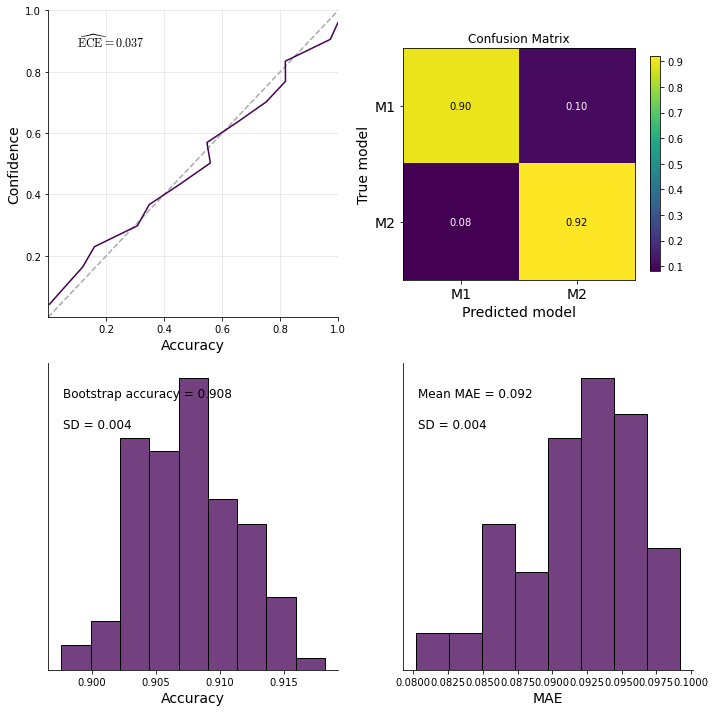

In [25]:
# Performance of the dropout output
perf_tester_dropout(evidence_net, summary_net, val_data, output_softmax=True, n_cal_bins=15)

In [15]:
# Performance of the evidential output
perf_tester(evidence_net, summary_net, val_data, output_softmax=False, n_cal_bins=15)

UnboundLocalError: local variable 'alpha' referenced before assignment

ECE = 0.036


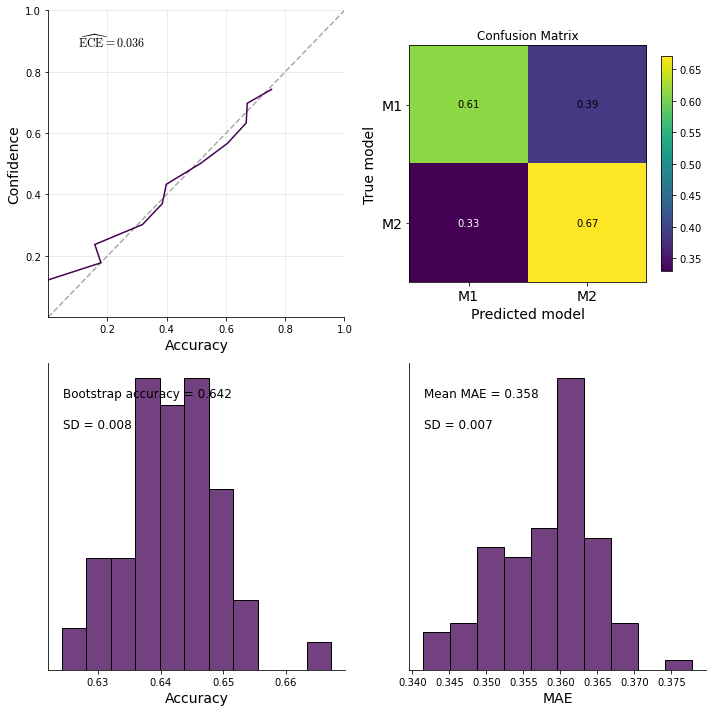

In [16]:
# Performance of the softmax output
perf_tester(evidence_net, summary_net, val_data, output_softmax=True, n_cal_bins=15)

UnboundLocalError: local variable 'alpha' referenced before assignment

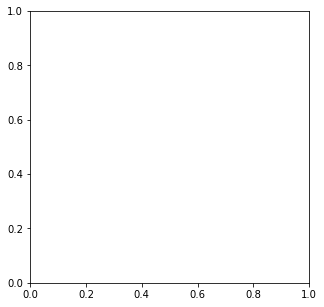

In [31]:
# Plot calibration with repetition uncertainty
fig, ax = plt.subplots(1, 1, figsize=(5,5))

m_true_r, m_soft_r = get_multiple_predictions(evidence_net, summary_net, partial(simulator, batch_size=n_data_sets, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2), 
                                          n_models=2, procedure='repeated', n_repetitions=20)

plot_calibration_curve_repetition_uncertainty(m_true_r, m_soft_r, narrow_ci=[0.025, 0.975], wide_ci=[0.25, 0.75], n_bins=15, ax=ax, 
                                    xlabel=True, ylabel=True, title=None, show_ece=True, show_legend=True)

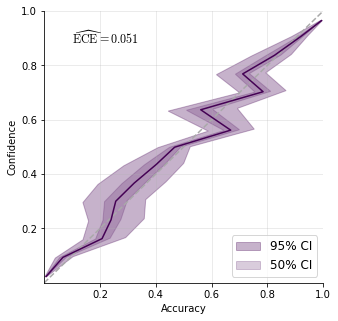

In [10]:
# Plot calibration with bootstrap uncertainty
fig, ax = plt.subplots(1, 1, figsize=(5,5))

m_true_b, m_soft_b = get_multiple_predictions(evidence_net, summary_net, partial(simulator, batch_size=n_data_sets, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2), 
                                          n_models=2, procedure='bootstrap', n_bootstrap=200)

plot_calibration_curve_repetition_uncertainty(m_true_b, m_soft_b, narrow_ci=[0.025, 0.975], wide_ci=[0.25, 0.75], n_bins=15, ax=ax, 
                                    xlabel=True, ylabel=True, title=None, show_ece=True, show_legend=True)

# Calculate Bayes factors for bridge sampling comparison

In [13]:
# Import training meta-information? (if network was loaded from checkpoint)

# TODO

In [26]:
# Import test data
val_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison','non_nested_models')
data_filename = "test_data.npy"
test_data = np.load(os.path.join(val_folder, data_filename), allow_pickle=True).item()

In [31]:
# hack to work with softmax output

def get_preds_and_bfs(evidence_net, summary_net, data, training_time_start, training_time_stop, losses):
    """ 
    Writes model predictions and resulting Bayes Factors for a given 
    array of datasets into a pandas DataFrame. 
    """

    n_datasets = data['X'].shape[0]
    dataset = np.arange(1,n_datasets+1)
    true_model = data['m'][:,1]

    # Predict
    inference_time_start = perf_counter()
    #m1_prob = np.array(evidence_net.predict(summary_net(data['X']), output_softmax=True)['m_probs'][:, 1], dtype = np.longdouble)
    m1_prob = np.mean(np.stack([np.array(evidence_net.predict(summary_net(data['X']), output_softmax=True)['m_probs'][:, 1], dtype = np.longdouble) for _ in range(100)]), axis=0)
    inference_time_stop = perf_counter()
    m0_prob = 1 - m1_prob
    selected_model = (m1_prob > 0.5)

    # Bayes Factors
    bayes_factor = m1_prob / m0_prob
    
    # Times
    training_time = np.repeat((training_time_stop-training_time_start), n_datasets)
    inference_time = np.repeat(((inference_time_stop-inference_time_start)/n_datasets), n_datasets)
    
    # Final epoch mean loss
    final_epoch_loss = np.repeat(np.mean(losses[10]), n_datasets)

    # Create DataFrame
    vals = np.c_[dataset, true_model, m0_prob, m1_prob, selected_model, bayes_factor,
                 training_time, inference_time, final_epoch_loss]
    names = ['dataset', 'true_model', 'm0_prob', 'm1_prob', 'selected_model', 'bayes_factor',
             'training_time', 'inference_time', 'final_epoch_loss']
    df = pd.DataFrame(vals, columns = names)
    df[["dataset", "true_model", "selected_model"]] = df[["dataset", "true_model", "selected_model"]].astype(int)
    
    return df


def log_with_inf_noise_addition(x):
    """ 
    Adjusts the model probabilities leading to Inf values by a minimal amount of noise, 
    recomputes the Bayes factors and then computes the log of the given array. 
    """
    
    noise = 0.000000001

    x_copy = x.copy()
    for i in range(x.shape[0]):
        if x.loc[i,'m0_prob'] == 0:
            print('Dataset with infinite BF: {}'.format(i))
            x_copy.loc[i,'m0_prob'] = x_copy.loc[i,'m0_prob'] + noise
            x_copy.loc[i,'m1_prob'] = x_copy.loc[i,'m1_prob'] - noise
            x_copy.loc[i,'bayes_factor'] = x_copy.loc[i,'m1_prob'] / x_copy.loc[i,'m0_prob']
    x_copy = np.log(x_copy['bayes_factor'])
    return x_copy

In [32]:
# Get NN predictions
comparison_results = get_preds_and_bfs(evidence_net, summary_net, test_data, training_time_start, training_time_stop, losses)
comparison_results.head(5)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.849637,0.150363,0,0.176973,1098.703923,0.022474,0.350755
1,2,0,0.944601,0.055399,0,0.058648,1098.703923,0.022474,0.350755
2,3,0,0.960675,0.039325,0,0.040935,1098.703923,0.022474,0.350755
3,4,1,0.254010,0.745990,1,2.936853,1098.703923,0.022474,0.350755
4,5,0,0.951234,0.048766,0,0.051266,1098.703923,0.022474,0.350755


In [33]:
# Export results
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d_BF_NN_softmax_dropout')
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison','non_nested_models')

comparison_results.to_csv(os.path.join(comparison_folder, filename), index = False)